In [1]:
import pickle 
import pandas as pd
from math import pi
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
#permite guardar el modelo serializandolo

def save_to_pickle(name, item):
    filehandler = open(name+".pkl", "wb")
    pickle.dump(item, filehandler)
    filehandler.close()

In [3]:
# pinta las metricas de cada epoca....

def plot_metric(history, metric, valida):
    train_metrics = history.history[metric]
    # if valida:
    #    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    if valida:
        val_metrics = history.history['val_' + metric]
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation ' + metric)
    else:
        plt.title('Training ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    if valida:
        plt.legend(["train_"+metric, 'val_' + metric])
    plt.show()

In [4]:
# creacion del modelo de red neuronal
# capa de entrada de usuarios:
#    codificados como one-hot,por lo tanto tiene de dimension el numero 
#    de usuarios distintos del conjunto

#



# K=32
# LR=1e-3
# num_users=943
# num_pelis=1682
# dim_users=dim_pelis=1
# peso_score=0,5  --> lo iremos variando para dar mas peso a entrenar las valoraciones o los géneros

def crear_modelo(K, LR, num_users, num_pelis, dim_users, dim_pelis, peso_score):
    user_input = tf.keras.layers.Input(shape=(dim_users,), name="input_usr")  # Variable-length sequence of ints
    usuarios_emb = tf.keras.layers.Embedding(input_dim=num_users, output_dim=K, name="embedding_usr")(user_input)
    usuarios = tf.keras.layers.Flatten(name="flatten_usr")(usuarios_emb)  # para pasar de (?,1,K) a (?,K)
    usr_emb_genr = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="usr_dot")(usuarios)  # (?, num_genres)
    #usr_emb_genr = tf.keras.layers.Dense(num_genres, activation='tanh', name="usr_dot")(usuarios)

    pelis_input = tf.keras.layers.Input(shape=(dim_pelis,), name="input_pelis")  # Variable-length sequence of ints
    pelis_emb = tf.keras.layers.Embedding(input_dim=num_pelis, output_dim=K, name="embedding_pelis")(pelis_input)
    pelis = tf.keras.layers.Flatten(name="flatten_pelis")(pelis_emb)  # para pasar de (?,1,K) a (?,K)
    genre_pred = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="genres")(pelis)  # (?, num_genres)
    # genre_pred = tf.keras.layers.Dense(num_genres, activation='tanh', name="genres")(pelis)  # (?, num_genres)

    score_pred = tf.keras.layers.Dot(axes=1, name="scores")([usr_emb_genr, genre_pred])

    model = tf.keras.Model(
        inputs=[user_input, pelis_input],
        outputs=[score_pred, genre_pred],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        # optimizer=keras.optimizers.RMSprop(1e-3),
        loss={
            "scores": tf.keras.losses.MeanSquaredError(),
            # "scores": keras.losses.MeanAbsoluteError(),
            "genres": tf.keras.losses.BinaryCrossentropy(),  # (from_logits=True),
        },
        loss_weights=[peso_score, 1 - peso_score],
        metrics=['mean_absolute_error', tf.keras.metrics.BinaryAccuracy()],
    )

    model_usr = tf.keras.Model(
        inputs=[user_input],
        outputs=[usr_emb_genr],
    )

    
    output_array2 = model.predict([valoraciones25M.user_id, valoraciones25M.item_id])
    

    return model, model_usr


In [5]:
def entrenar(VALIDATION, K, epochs, batch_size, learning_rate, peso_score, num_users, num_pelis, dim_input_users,
             dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test):
    # SE CREA EL MODELO
    model, mod_usr = crear_modelo(K, learning_rate, num_users, num_pelis, dim_input_users, dim_input_pelis, peso_score)

    # ENTRENAMOS EL MODELO Y EVALUAMOS EN EL CONJUNTO DE TEST
    if VALIDATION:
        # DECLARAMOS UN OBJETO EARLY STOPPING PARA DECIDIR LA MEJOR EPOCH
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        # early_stop = EarlyStopping(monitor='val_scores_loss', patience=20)
        csv_logger = tf.keras.callbacks.CSVLogger("model/model_history_log.csv", append=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_T_{epoch:06d}.h5', save_best_only=True)
        history = model.fit(x=[X_train.user_id, X_train.item_id], y=[y_train.rating, y_train[col_items25M]],
                            validation_data=([X_dev.user_id, X_dev.item_id], [y_dev.rating, y_dev[col_items25M]]),
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stop, checkpoint,csv_logger])
        print('Mejor epoch:', early_stop.stopped_epoch)
        media_en_train = y_train['rating'].mean()
    else:
        if epochs == 0:
            epochs = 1000
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_T+D_{epoch:06d}.h5')
        history = model.fit(x=[X_train_dev.user_id, X_train_dev.item_id],
                            y=[y_train_dev.rating, y_train_dev[col_items]],
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])
        media_en_train = y_train_dev['rating'].mean()
        usr_emb_g = mod_usr.predict([X_test.user_id])

    losses = model.evaluate([X_test.user_id, X_test.item_id], [y_test.rating, y_test[col_items25M]])
    print('\t*-* Test                         loss: %.4f' % losses[0])
    print('\t*-* Test                   score_loss: %.4f' % losses[1])
    print('\t*-* Test                  gender_loss: %.4f' % losses[2])
    print('\t*-* Test             MAE sobre scores: %.4f' % losses[3])
    print('\t*-* Test binary accuracy sobre genres: %.4f' % losses[6])

    print("excel: %.4f\t%.4f\t%.4f\t%.4f\t%.4f" % (losses[0], losses[1], losses[2], losses[3], losses[6]))

    prediction = model.predict([X_test.user_id, X_test.item_id])
    print('Test MAE    modelo: %.4f' % (sum(abs(y_test['rating'] - prediction[0].flatten())) / y_test.shape[0]))
    print('Test MAE Sys-Media: %.4f' % (sum(abs(y_test['rating'] - media_en_train)) / y_test.shape[0]))

    # GRÁFICOS
    # plot_metric(history, 'loss', valida=VALIDATION)
    # plot_metric(history, 'scores_loss', valida=VALIDATION)
    plot_metric(history, 'genres_loss', valida=VALIDATION)
    plot_metric(history, 'scores_mean_absolute_error', valida=VALIDATION)
    # plot_metric(history, 'genres_binary_accuracy', valida=VALIDATION)

    if VALIDATION:
        return model, early_stop.stopped_epoch
    else:
        return model, prediction, usr_emb_g



In [6]:
def radar_chart(line_out, df_train_dev, items, names, unames, pnames, prnames):
    print("-------------------------------------------------------------------------------------------------")
    print("----- radar_chart: genera el radar_chart ")
    print("-------------------------------------------------------------------------------------------------")
    num_user = line_out.user_id  #.iloc[line]
    num_peli = line_out.item_id  #.iloc[line]
    titulo_peli = items[items.item_id == num_peli].title.values[0]

    # number of variable
    categories = names  # list(df)[2:]  # para quitar user_id y rating de las etiquetas
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    plt.figure(figsize=(6, 7))
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable
    plt.xticks(angles[:-1], categories)

    # ------- PART 2: Add plots
    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable

    # Usuario
    # values_user = line_out[unames].iloc[line].values.tolist()
    values_user = line_out[unames].values.tolist()
    values_user += values_user[:1]
    ax.plot(angles, values_user, linewidth=1, linestyle='solid', label="Usuario - predicho")
    ax.fill(angles, values_user, 'b', alpha=0.1)

    # Predicción géneros película
    values_peli = line_out[pnames].values.tolist()
    values_peli += values_peli[:1]
    ax.plot(angles, values_peli, linewidth=1, linestyle='solid', label="Predicho - "+titulo_peli)
    ax.fill(angles, values_peli, 'r', alpha=0.1)

    # géneros película verdaderos
    true_values_peli = line_out[prnames].values.tolist()
    true_values_peli += true_values_peli[:1]
    ax.plot(angles, true_values_peli, linewidth=1, linestyle='solid', label="Real - "+titulo_peli)
    ax.fill(angles, true_values_peli, 'g', alpha=0.1)

    # Draw ylabels
    ax.set_rlabel_position(0)
    v = max(max(values_user), max(values_peli)) / 4
    plt.yticks([v, v*2, v*3], [str(round(v, 4)), str(round(v*2, 4)), str(round(v*3, 4))], color="grey", size=7)
    plt.ylim(0, max(max(values_user), max(values_peli)))

    # Add legend
    plt.legend(loc='lower left', bbox_to_anchor=(-0.15, -0.23))

    nota_media_users = df_train_dev['rating'].groupby(df_train_dev['user_id']).mean().reset_index()
    nota_media_pelis = df_train_dev['rating'].groupby(df_train_dev['item_id']).mean().reset_index()
    nota_media_usr = nota_media_users[nota_media_users.user_id == num_user].rating.values[0]
    nota_media_peli = nota_media_pelis[nota_media_pelis.item_id == num_peli].rating.values[0]
    titulo = 'Usuario ' + str(int(num_user)) + ' (nota media: ' + str(np.round(nota_media_usr, 2)) + ')\n' + \
             titulo_peli + ' (nota media: ' + str(np.round(nota_media_peli, 2)) + ')\n' + \
             ' Nota predicha: ' + str(np.round(line_out.rating, 2))

    plt.title(titulo)
    # Show the graph
    plt.show()


In [7]:

def topNrankings(N, line_out, names, unames, pnames, prnames, verbose=False):
    # line_out = df_out.iloc[7]
    usuario = line_out[unames].copy()
    usuario.rename(dict(zip(unames, names)), axis='columns', inplace=True)
    peli = line_out[pnames].copy()
    peli.rename(dict(zip(pnames, names)), axis='columns', inplace=True)
    peli_real = line_out[prnames].copy()
    peli_real.rename(dict(zip(prnames, names)), axis='columns', inplace=True)
    top5user = usuario.sort_values(ascending=False)[0:N]
    top5peli = peli.sort_values(ascending=False)[0:N]
    top5real = peli_real.sort_values(ascending=False)[0:N]
    inters_genres = top5user.index & top5peli.index
    if verbose:
        print("-------------------------------------------------------------------------------------------------")
        print("----- topNrankings: muestra los TopN y calcula la intersección ")
        print("-------------------------------------------------------------------------------------------------")
        print("Top", N, "de géneros del usuario según el modelo:")
        print(top5user)
        print("Top", N, "de géneros de la película según el modelo:")
        print(top5peli)
        print("Top", N, "de géneros de la película según MovieLens:")
        print(top5real)
        print("Intersección usuario-película en top", N, "según el modelo:")
        print(inters_genres)
        print("Número de elementos en la intersección:", len(inters_genres))
        print("Puntuación predicha (real) para la película: %.2f (%.0f)" % (line_out.rating, line_out.rat_real))
    return len(inters_genres)


In [8]:

def genres_bar_chart(genre_names, gen_reales, gen_predichos):
    x = np.arange(len(genre_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, gen_reales, width, label='Géneros reales')
    rects2 = ax.bar(x + width / 2, gen_predichos, width, label='Géneros predichos')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('media')
    ax.set_title('Media de géneros de las películas')
    ax.set_xticks(x)
    ax.set_xticklabels(genre_names, rotation='vertical')
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()


In [9]:

def compara_generos(df_out, pnames, prnames):
    dfo = df_out[pnames + prnames].groupby(df_out['item_id']).mean().reset_index()
    # genres_bar_chart(names, dfo[prnames].sum(), dfo[pnames].sum())
    genres_bar_chart(names, dfo[prnames].mean(), dfo[pnames].mean())
    print('Correlación: ', np.corrcoef(dfo[prnames].mean(), dfo[pnames].mean())[0,1])
    dfo[dfo[pnames] < 0.5] = 0
    dfo[dfo[pnames] >= 0.5] = 1
    genres_por_peli_pred = np.sum(dfo[pnames], axis=1)
    genres_por_peli_real = np.sum(dfo[prnames], axis=1)
    print("-------------------------------------------------------------------------------------------------")
    print("----- compara_generos: genera el barchart y muestra media de géneros por película")
    print("-------------------------------------------------------------------------------------------------")
    print("Media de géneros por película en test (real):", genres_por_peli_real.mean())
    print("Media de géneros por película en test (pred):", genres_por_peli_pred.mean())
    dfo['dif_genres'] = genres_por_peli_pred - genres_por_peli_real
    dfo.to_csv('dif_genres.csv', sep=';', decimal=',')



In [10]:
def explica(linea, df_out, df_train_dev, items, names, unames, pnames, prnames):
    print("-------------------------------------------------------------------------------------------------")
    print("----- explica: muestra qué géneros influyen más en la valoración")
    print("-------------------------------------------------------------------------------------------------")
    importancia_genres = np.multiply(df_out[unames], df_out[pnames])
    print("Valor predicho: %.2f" % (importancia_genres.iloc[linea].sum()))
    genres_ordenados = importancia_genres.iloc[linea].sort_values(ascending=False)
    print("Géneros que más aportan:")
    print(genres_ordenados[0:5])
    suma = genres_ordenados[0:5].sum()
    print("Aportan el %.2f%% de la nota predicha (%.2f de %.2f)" % (suma*100 / importancia_genres.iloc[linea].sum(),
                                                                    suma, importancia_genres.iloc[linea].sum()))
    # aportación de los géneros con predicción >=05
    mask = df_out.iloc[linea][pnames] >= 0.5
    gen_ge_05 = importancia_genres.iloc[linea, mask.values.tolist()]
    print("Aportación de los géneros >= 0.5:")
    print(gen_ge_05.sort_values(ascending=False))
    suma = gen_ge_05.sum()
    print("Aportan el %.2f%% de la nota predicha (%.2f de %.2f)" % (suma * 100 / importancia_genres.iloc[linea].sum(),
                                                                    suma, importancia_genres.iloc[linea].sum()))


In [11]:
# MAIN
# ---------------------------------------------------------------------------------------------------------------------

#PATH = '/Users/antonio/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-100k/'
#path alfa
PATH25M='../paper_generos_peliculas/XAI_movies/cjtos/ml-25M/'
#path M1
#PATH25M='/Users/antonio/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-25M/'

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# VALORACIONES
# ---------------------------------------------------------------------------------------------------------------------
#valoraciones = pd.read_csv(PATH+'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])


valoraciones25M= pd.read_csv(PATH25M+'ratings.csv',header=1,names=['user_id', 'item_id', 'rating', 'timestamp'])

# quito el timestamp porque no me interesa
#valoraciones.drop(['timestamp'], axis='columns', inplace=True)
valoraciones25M.drop(['timestamp'], axis='columns', inplace=True)

# de momento dejo el rating como un problema de regresión
#print(valoraciones)
print(valoraciones25M)
num_ejem25M = valoraciones25M.shape[0]
num_users25M = valoraciones25M.user_id.max()+1  # 943, del 1 al 943. El +1 es porque empieza en 0
num_pelis25M = valoraciones25M.item_id.max()+1  # 1682, del 1 al 1682

          user_id  item_id  rating
0               1      306     3.5
1               1      307     5.0
2               1      665     5.0
3               1      899     3.5
4               1     1088     4.0
...           ...      ...     ...
25000089   162541    50872     4.5
25000090   162541    55768     2.5
25000091   162541    56176     2.0
25000092   162541    58559     4.0
25000093   162541    63876     5.0

[25000094 rows x 3 columns]


In [12]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ITEMS (PELÍCULAS)
# ---------------------------------------------------------------------------------------------------------------------
#items = pd.read_csv(PATH+'u.item', sep='|', names=['item_id', 'title', 'RD', 'VRD', 'IMDB', 'unknown', 'Action',
#                                                   'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
#                                                   'Documentary', 'Drama', 'Fantasy', 'FilmNoir', 'Horror', 'Musical',
#                                                   'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western'])
#print(items)
# de las películas me quedo sólo con los géneros de las mismas. El resto de campos los elimino
# dejo el item_id para comprobaciones
# titles = items.loc[:, ['item_id', 'title']]

#items.drop(['RD', 'VRD', 'IMDB', 'unknown'], axis='columns', inplace=True)
#print(items)

#num_genres = items.shape[1]-2  # el -2 es para no contar el item_id ni el título. Son 18 géneros

items25M=pd.read_csv(PATH25M+'movies_one_hot_genre.csv')
                     #,header=0,names=['item_id', 'genero_desconocido','Action',
                      #                                         'Adventure','Animation','Children','Comedy','Crime',
                       #                                        'Documentary','Drama','Fantasy','Film-noir','horror','imax',
                        #                                       'Musical','Mystery','Romance','Sci-fi','thriller','War','literal','titulo'])
                                                               
                                                               
items25M.drop(['0_(no genres listed)'],axis='columns',inplace=True)
items25M.drop(['literal'],axis='columns',inplace=True)
num_genres = items25M.shape[1]-2
print(items25M)


        item_id  0_Action  0_Adventure  0_Animation  0_Children  0_Comedy  \
0           1.0       0.0          0.0          1.0         1.0       1.0   
1           2.0       0.0          0.0          0.0         1.0       0.0   
2           3.0       0.0          0.0          0.0         0.0       0.0   
3           4.0       0.0          0.0          0.0         0.0       0.0   
4           5.0       0.0          0.0          0.0         0.0       0.0   
...         ...       ...          ...          ...         ...       ...   
62418  209157.0       0.0          0.0          0.0         0.0       0.0   
62419  209159.0       0.0          0.0          0.0         0.0       0.0   
62420  209163.0       0.0          0.0          0.0         0.0       0.0   
62421  209169.0       0.0          0.0          0.0         0.0       0.0   
62422  209171.0       0.0          1.0          0.0         0.0       0.0   

       0_Crime  0_Documentary  0_Drama  0_Fantasy  ...  0_Horror  0_IMAX  \

In [13]:
#items25M.to_csv("/Users/antonio/OneDrive - farmasturias.org/doctorado/paper_generos_peliculas/XAI_movies/cjtos/ml-25M/items25.csv")

In [14]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# PREPARANDO EL CONJUNTO DE DATOS
# ---------------------------------------------------------------------------------------------------------------------
#cjto = valoraciones
cjto25M=valoraciones25M
# genera un indice con los generos de las peliculas

#col_items = items.columns.drop(['item_id', 'title'])
#print(col_items)
col_items25M = items25M.columns.drop(['title','item_id'])
print(col_items25M)

# añado las columnas para el item ceros
#cjto[col_items] = np.zeros((cjto.shape[0], col_items.shape[0]), dtype='int32')
cjto25M[col_items25M] = np.zeros((cjto25M.shape[0], col_items25M.shape[0]), dtype='int32')


Index(['0_Action', '0_Adventure', '0_Animation', '0_Children', '0_Comedy',
       '0_Crime', '0_Documentary', '0_Drama', '0_Fantasy', '0_Film-Noir',
       '0_Horror', '0_IMAX', '0_Musical', '0_Mystery', '0_Romance', '0_Sci-Fi',
       '0_Thriller', '0_War', '0_Western'],
      dtype='object')


In [15]:
cjto25M

,user_id,item_id,rating,0_Action,0_Adventure,0_Animation,0_Children,0_Comedy,0_Crime,0_Documentary,...,0_Film-Noir,0_Horror,0_IMAX,0_Musical,0_Mystery,0_Romance,0_Sci-Fi,0_Thriller,0_War,0_Western
0,1,306,3.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,307,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,665,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,899,3.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1088,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25000089,162541,50872,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25000090,162541,55768,2.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25000091,162541,56176,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25000092,162541,58559,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
cjto25M=pd.read_csv("../paper_generos_peliculas/XAI_movies/cjtos/ml-25M/cjto25M.csv")

In [17]:
 #sustituido por un procesado en sql que me da ya el cvs correcto se importa arriba
# relleno los items con sus valores
#for i in range(items25M.shape[0]):
#    num_item25M = items25M.iloc[i].item_id
#    if i % 40 == 0:
#        print("item:", num_item25M)
    #cjto25M.loc[cjto25M.item_id == num_item25M, col_items25M] = items25M.iloc[i, 2:].to_list()  # se salta item_id y title
#    cjto25M.loc[cjto25M.item_id == num_item25M, col_items25M] = items25M.iloc[i, 1:-1].to_list()  # se salta item_id (primer item y title (ultimo)) y title
    #print(items25M.iloc[i, 1:-1].to_list())
    #print(cjto25M.loc[cjto25M.item_id == num_item25M, col_items25M])
# se almacenas en un fichero los ejemplos
# cjto.to_pickle('SPARSES/ML100K_CASOS_USO.pkl')

# X / y
#X = cjto25M[['user_id', 'item_id']].copy()

#y = cjto25M[col_items25M.insert(0, 'rating')].copy()


In [18]:
X = cjto25M[['user_id', 'item_id']].copy()
X

,user_id,item_id
0,1,306
1,1,307
2,1,665
3,1,899
4,1,1088
...,...,...
25000089,162541,50872
25000090,162541,55768
25000091,162541,56176
25000092,162541,58559


In [19]:
y = cjto25M[col_items25M.insert(0, 'rating')].copy()
y

,rating,0_Action,0_Adventure,0_Animation,0_Children,0_Comedy,0_Crime,0_Documentary,0_Drama,0_Fantasy,0_Film-Noir,0_Horror,0_IMAX,0_Musical,0_Mystery,0_Romance,0_Sci-Fi,0_Thriller,0_War,0_Western
0,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25000089,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25000090,2.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25000091,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25000092,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:

TEST = 0.10
DEV = 0.10

# TRAIN/DEV/TEST SPLIT (sin estratificar para prevenir errores)

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, stratify=None, test_size=TEST, random_state=2032)

X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, stratify=None,
                                                  test_size=DEV, random_state=2032)

print("% test =", TEST, "\n% dev =", DEV)
print("X_train:", X_train.shape)
print("X_dev  :", X_dev.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_dev  :", y_dev.shape)
print("y_test :", y_test.shape)

% test = 0.1 
% dev = 0.1
X_train: (20250075, 2)
X_dev  : (2250009, 2)
X_test : (2500010, 2)
y_train: (20250075, 20)
y_dev  : (2250009, 20)
y_test : (2500010, 20)


In [21]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ENTRENAMIENTO
# ---------------------------------------------------------------------------------------------------------------------
K = 32
learning_rate = 1e-3
dim_input_users = 1  # el entero a partir del cual se calcula el embedding ##????
dim_input_pelis = 1  # el entero a partir del cual se calcula el embedding ##????
tam_batch = 512 
max_epochs = 1000 
peso_score = 0.5  # valor entre 0 y 1.0

In [22]:
#from tensorflow.keras import models
#batch_size=512
#epochs=1
#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_T_{epoch:06d}.h5', save_best_only=True)
       
#new_model = models.load_model('model/model_T_000077.h5')
#history = new_model.fit(x=[X_train.user_id, X_train.item_id], y=[y_train.rating, y_train[col_items25M]],
#                            validation_data=([X_dev.user_id, X_dev.item_id], [y_dev.rating, y_dev[col_items25M]]),
#                            epochs=epochs, batch_size=batch_size, callbacks=[early_stop, checkpoint])
        

Epoch 1/1000
39551/39551 [==============================] - 1016s 26ms/step - loss: 0.5731 - scores_loss: 0.8354 - genres_loss: 0.3108 - scores_mean_absolute_error: 0.7026 - scores_binary_accuracy: 0.0311 - genres_mean_absolute_error: 0.2619 - genres_binary_accuracy: 0.9971 - val_loss: 0.4852 - val_scores_loss: 0.7319 - val_genres_loss: 0.2385 - val_scores_mean_absolute_error: 0.6571 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2091 - val_genres_binary_accuracy: 0.9964
Epoch 2/1000
39551/39551 [==============================] - 1017s 26ms/step - loss: 0.4787 - scores_loss: 0.7169 - genres_loss: 0.2404 - scores_mean_absolute_error: 0.6491 - scores_binary_accuracy: 0.0310 - genres_mean_absolute_error: 0.2100 - genres_binary_accuracy: 0.9956 - val_loss: 0.4772 - val_scores_loss: 0.7123 - val_genres_loss: 0.2422 - val_scores_mean_absolute_error: 0.6463 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2106 - val_genres_binary_accuracy: 0.9

39551/39551 [==============================] - 978s 25ms/step - loss: 0.4436 - scores_loss: 0.6257 - genres_loss: 0.2615 - scores_mean_absolute_error: 0.6023 - scores_binary_accuracy: 0.0310 - genres_mean_absolute_error: 0.2165 - genres_binary_accuracy: 0.9740 - val_loss: 0.4631 - val_scores_loss: 0.6662 - val_genres_loss: 0.2600 - val_scores_mean_absolute_error: 0.6246 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2158 - val_genres_binary_accuracy: 0.9760
Epoch 34/1000
39551/39551 [==============================] - 978s 25ms/step - loss: 0.4432 - scores_loss: 0.6247 - genres_loss: 0.2618 - scores_mean_absolute_error: 0.6018 - scores_binary_accuracy: 0.0310 - genres_mean_absolute_error: 0.2166 - genres_binary_accuracy: 0.9735 - val_loss: 0.4629 - val_scores_loss: 0.6636 - val_genres_loss: 0.2621 - val_scores_mean_absolute_error: 0.6213 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2170 - val_genres_binary_accuracy: 0.9751
Epoch 35/1

39551/39551 [==============================] - 976s 25ms/step - loss: 0.4408 - scores_loss: 0.6168 - genres_loss: 0.2648 - scores_mean_absolute_error: 0.5975 - scores_binary_accuracy: 0.0311 - genres_mean_absolute_error: 0.2175 - genres_binary_accuracy: 0.9695 - val_loss: 0.4622 - val_scores_loss: 0.6644 - val_genres_loss: 0.2601 - val_scores_mean_absolute_error: 0.6258 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2146 - val_genres_binary_accuracy: 0.9742
Epoch 66/1000
39551/39551 [==============================] - 977s 25ms/step - loss: 0.4408 - scores_loss: 0.6168 - genres_loss: 0.2648 - scores_mean_absolute_error: 0.5976 - scores_binary_accuracy: 0.0311 - genres_mean_absolute_error: 0.2175 - genres_binary_accuracy: 0.9696 - val_loss: 0.4621 - val_scores_loss: 0.6601 - val_genres_loss: 0.2640 - val_scores_mean_absolute_error: 0.6204 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2172 - val_genres_binary_accuracy: 0.9722
Epoch 67/1

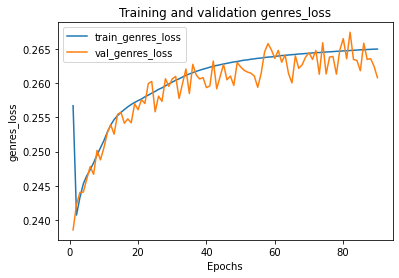

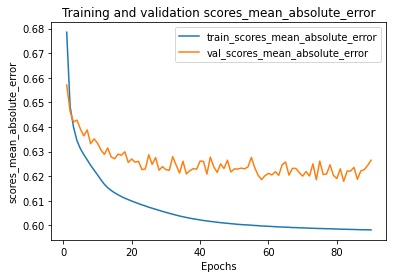

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_usr (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_pelis (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_usr (Embedding)       (None, 1, 32)        5201344     input_usr[0][0]                  
__________________________________________________________________________________________________
embedding_pelis (Embedding)     (None, 1, 32)        6693504     input_pelis[0][0]                
______________________________________________________________________________________________

In [23]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN -> DEV Y TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = True
model, n_epochs = entrenar(VALIDATION, K, max_epochs, tam_batch, learning_rate, peso_score, num_users25M, num_pelis25M,
                           dim_input_users, dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)

model.summary()

39551/39551 [==============================] - 978s 25ms/step - loss: 0.4397 - scores_loss: 0.6130 - genres_loss: 0.2664 - scores_mean_absolute_error: 0.5955 - scores_binary_accuracy: 0.0311 - genres_mean_absolute_error: 0.2178 - genres_binary_accuracy: 0.9680 - val_loss: 0.4620 - val_scores_loss: 0.6590 - val_genres_loss: 0.2651 - val_scores_mean_absolute_error: 0.6199 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2173 - val_genres_binary_accuracy: 0.9718
Epoch 97/1000
39551/39551 [==============================] - 976s 25ms/step - loss: 0.4395 - scores_loss: 0.6125 - genres_loss: 0.2664 - scores_mean_absolute_error: 0.5954 - scores_binary_accuracy: 0.0311 - genres_mean_absolute_error: 0.2178 - genres_binary_accuracy: 0.9680 - val_loss: 0.4624 - val_scores_loss: 0.6593 - val_genres_loss: 0.2654 - val_scores_mean_absolute_error: 0.6199 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2173 - val_genres_binary_accuracy: 0.9696
Mejor epoch: 96

In [ ]:
losses = model.evaluate([X_test.user_id, X_test.item_id], [y_test.rating, y_test[col_items25M]])
print('\t*-* Test                         loss: %.4f' % losses[0])
print('\t*-* Test                   score_loss: %.4f' % losses[1])
print('\t*-* Test                  gender_loss: %.4f' % losses[2])
print('\t*-* Test             MAE sobre scores: %.4f' % losses[3])
print('\t*-* Test binary accuracy sobre genres: %.4f' % losses[6])
print("excel: %.4f\t%.4f\t%.4f\t%.4f\t%.4f" % (losses[0], losses[1], losses[2], losses[3], losses[6]))



39551/39551 [==============================] - 978s 25ms/step - loss: 0.4397 - scores_loss: 0.6130 - genres_loss: 0.2664 - scores_mean_absolute_error: 0.5955 - scores_binary_accuracy: 0.0311 - genres_mean_absolute_error: 0.2178 - genres_binary_accuracy: 0.9680 - val_loss: 0.4620 - val_scores_loss: 0.6590 - val_genres_loss: 0.2651 - val_scores_mean_absolute_error: 0.6199 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2173 - val_genres_binary_accuracy: 0.9718
Epoch 97/1000
39551/39551 [==============================] - 976s 25ms/step - loss: 0.4395 - scores_loss: 0.6125 - genres_loss: 0.2664 - scores_mean_absolute_error: 0.5954 - scores_binary_accuracy: 0.0311 - genres_mean_absolute_error: 0.2178 - genres_binary_accuracy: 0.9680 - val_loss: 0.4624 - val_scores_loss: 0.6593 - val_genres_loss: 0.2654 - val_scores_mean_absolute_error: 0.6199 - val_scores_binary_accuracy: 0.0310 - val_genres_mean_absolute_error: 0.2173 - val_genres_binary_accuracy: 0.9696

In [ ]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN+DEV -> TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = False
model, prediction, usr_emb_genres = entrenar(VALIDATION, K, n_epochs, tam_batch, learning_rate, peso_score, num_users,
                                        num_pelis, dim_input_users, dim_input_pelis,
                                        X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)

save_to_pickle('ml100k_prediction', prediction)

In [ ]:
# se crea un df con los datos de TRAIN+DEV [idusr, iditem, rating, genres]
df_train_dev = X_train_dev.copy()
df_train_dev[y_test.columns] = y_train_dev

# unos que hay en la predicción y en el test
print('UNOS en la predicción:', sum(sum(prediction[1] > 0.5)))
print('UNOS en el test:      ', sum(sum(y_test.values[:, 1:] > 0.5)))

# se crea un df con los datos de TEST [idusr, iditem, rating, genres]
# df_test = X_test.copy()
# df_test[y_test.columns] = y_test

# se crea un df con los datos PREDICHOS [idusr, iditem, rating, genres]
# df_pred = X_test.copy()
# df_pred['rating'] = prediction[0]
# df_pred[y_test.columns[1:]] = prediction[1]

# se crea un dataframe con toda la salida
df_out = X_test.copy()
df_out['rating'] = prediction[0]
df_out['rat_real'] = y_test['rating']
unames = ['u_' + g for g in y_test.columns[1:]]
df_out[unames] = usr_emb_genres  # esto es el mapeado de usuarios en el espacio de géneros
pnames = ['p_' + g for g in y_test.columns[1:]]
df_out[pnames] = prediction[1]  # esto es el mapeado de películas en el espacio de géneros
prnames = ['pr_' + g for g in y_test.columns[1:]]  # pr = películas real
df_out[prnames] = y_test[y_test.columns.drop('rating')]  # esto son los géneros de las películas según MovieLens

# lista con los nombre de los géneros
names = y_test.columns[1:]

# esto es para calcular la intersección de géneros en el top 5 y 10
# esto tarda un poco, así que lo comento y **sólo hay que descomentarlo para los RESULTADOS FINALES**
#df_out['intersecTop5'] = df_out.apply(lambda row: topNrankings(5, row, names, unames, pnames, prnames), axis=1)
#df_out['intersecTop10'] = df_out.apply(lambda row: topNrankings(10, row, names, unames, pnames, prnames), axis=1)
#df_out.to_csv('salida.csv', sep=';', decimal=',')


# hace el barchart
compara_generos(df_out, pnames, prnames)

EXPLICA = True
if EXPLICA:
    # Este código es para ver la recomendación que se hace a un usuario sobre las películas que ha valorado en el test
    # Se cogen las películas que ha valorado y se ordenan por el valor predicho por el modelo
    # Después se analiza y explica la recomendación de la película con mayor valoración (línea 0)
    num_usuario = 542  # 712 puede ser un buen ejemplo, 4 starwars, 8 pulpfiction, 9 elpacienteingles

    print("  ---***--- PREDICCIÓN PARA EL USUARIO %d ---***---" %(num_usuario))
    out_by_user = df_out[df_out.user_id == num_usuario].sort_values(by='rating', ascending=False)
    linea = 0  # en la línea 0 de out_by_user está la más valorada y por tanto la recomendada
    # radar_chart(df_out.iloc[linea], df_train_dev, items, names, unames, pnames, prnames)
    radar_chart(out_by_user.iloc[linea], df_train_dev, items, names, unames, pnames, prnames)
    topNrankings(5, out_by_user.iloc[linea], names, unames, pnames, prnames, verbose=True)
    explica(linea, out_by_user, df_train_dev, items, names, unames, pnames, prnames)

# esta es la media de géneros en las películas evaluadas por los usuarios
# NO tiene en cuenta las valoraciones
# gustos_usuarios_train = df_train_dev[y_test.columns].groupby(df_train_dev['user_id']).mean().reset_index()


# la predicción que se hace del género de las películas puede ser ligeramente diferente
# de los géneros reales. Eso haría que la proyección de los usuarios en el espacio de los
# géneros sirva para hacer predicciones mejores
# mostar: la proyección del usuario y la película en el espacio de géneros. Ahí se verá que
# géneros son importantes para el usuario a la hora de puntuar la película. Además se puede
# comparar el vector de géneros verdadero de la película con el predicho.
# Hay que ver cómo se hace para que el modelo mapee los usuarios en el espacio de los géneros
# para poder mostrarlos en la explicación

print('hiperparámetros: K=%d, batch_size=%d, learning_rate=%f, peso_score=%.2f' % (K, tam_batch, learning_rate,
                                                                                   peso_score))
print("FIN")
